In [8]:
import cv2
import json
import kornia as K
import math
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import re

from kornia.geometry import ImageRegistrator
from pathlib import Path
from PIL import Image

%matplotlib inline

cwd = Path.cwd()
data_folder = Path(cwd, 'dataset-sample')
reg_data_folder = Path(cwd, 'reg-data')

In [3]:
LABEL_IMG_PATTERN = '.*\.JPG'
LABEL_MASK_PATTERN = '.*\.json'
MSI_IMG_PATTERN = '.*\.png'


class Sample:

    def __init__(self, data_folder, sample_info):
        self.data_folder = data_folder
        self.id = None
        self.sample_path = None
        self.references = None
        self.data = None
        self._init_sample_info(sample_info)

    def _init_sample_info(self, sample_info):
        self.id = sample_info.get('id')
        self.sample_path = Path(self.data_folder, self.id)
        self.references = sample_info.get('ref_runs')
        self.data = sample_info.get('data_runs')

    def __repr__(self):
        return f"Sample(id={self.id})"
    
    # Data Images
    def get_data_paths(self, with_cap=True):
        """Return list of key-value pairs of label image and run image paths.
        
        Return: [
            {
                'label_img_path': Path,
                'label_mask_path': Path,
                'run_img_paths': [Path, Path, ...]
            },
        ]
        """
        
        labelled_folder = self.data.get('capillary').get('included') if with_cap else self.data.get('capillary').get('excluded')
        labelled_img_path = Path(self.sample_path, 'Labelling data', 'Definitive segmentation', labelled_folder)

        paths = []
        run_group = self.data.get('runs').keys()
        for group in run_group:
            group_path = Path(labelled_img_path, group)
            label_img_path = [x for x in group_path.iterdir() if re.match(LABEL_IMG_PATTERN, x.name)][0]
            label_mask_path = [x for x in group_path.iterdir() if re.match(LABEL_MASK_PATTERN, x.name)][0]

            run_ids = self.data.get('runs').get(group)
            for run_id in run_ids:
                run_path = Path(data_folder, self.id, run_id)
                run_img_paths = [x for x in run_path.iterdir() if re.match(MSI_IMG_PATTERN, x.name)]

                paths.append({
                    'label_img_path': label_img_path,
                    'label_mask_path': label_mask_path,
                    'run_img_paths': sorted(run_img_paths)
                })
        
        return paths

    # Reference Images
    def get_reference_paths(self):
        """Return list of key-value pairs of reference image paths.
        
        Return: {
            'orient': Path,
            'white': Path,
            'dark': Path
        }
        """
        
        paths = {}
        ref_imgs = self.references.keys()
        for ref_img in ref_imgs:
            run_ids = self.references.get(ref_img)
            run_paths = [Path(data_folder, self.id, run_id) for run_id in run_ids]
            run_img_paths = [x for x in run_paths[0].iterdir() if re.match(MSI_IMG_PATTERN, x.name)]

            paths[ref_img] = sorted(run_img_paths)
        
        return paths
    
    # Reference Images
    @property
    def orient_ref_path(self):
        return self.get_reference_paths().get('orient')

    @property
    def white_ref_path(self):
        return self.get_reference_paths().get('white')

    @property
    def dark_ref_path(self):
        return self.get_reference_paths().get('dark')


sample_infos = json.load(Path(data_folder, 'hs-info.json').open())
samples = [Sample(data_folder, sample_info) for sample_info in sample_infos.get('data')]

(-0.5, 1279.5, 1023.5, -0.5)

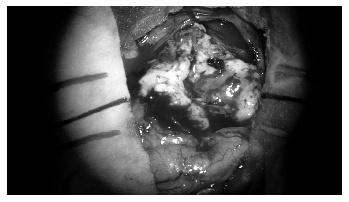

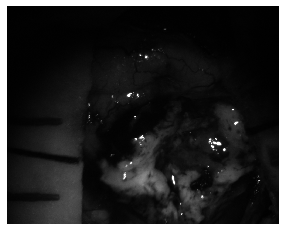

In [16]:
test_sample = samples[0]
test_runs = test_sample.get_data_paths()[9]

# source_img = test_runs.get('run_img_paths')[14]
# source_img = np.asarray(Image.open(source_img).convert('L'))
# source_img = cv2.flip(source_img, 0)

# target_img = test_runs.get('label_img_path')
# target_img = np.asarray(Image.open(target_img).convert('L'))

source_img = test_runs.get('label_img_path')
# source_img = np.asarray(Image.open(source_img).convert('L'))
# source_img = cv2.flip(source_img, 0)
source_img = cv2.imread(str(source_img), cv2.IMREAD_GRAYSCALE)

target_img = test_runs.get('run_img_paths')[16]
# target_img = np.asarray(Image.open(target_img).convert('L'))
target_img = cv2.imread(str(target_img), cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots()
ax.imshow(source_img, 'gray')
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(target_img, 'gray')
ax.axis('off')

In [20]:
registrator = ImageRegistrator('similarity')
src_tensor = K.utils.image_to_tensor(source_img, False).float()
tgt_tensor = K.utils.image_to_tensor(target_img, False).float()
homo = registrator.register(src_tensor, tgt_tensor)

ValueError: Cannot register images of different shapes                              torch.Size([1, 1, 67, 120]) torch.Size([1, 1, 64, 80]) 